In [127]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from pathlib import Path
from six.moves.urllib.request import urlopen
import soundfile as sf
import numpy as np
import pandas as pd
from scipy import signal, stats, interpolate

import matplotlib.pyplot as plt
from scipy.io import wavfile

Download delle tracce audio a 256kHz. Per il criterio di Nyquist il massimo suono registrabile, senza aliasing, ho una frequenza dimezzata rispetto al sample rate. Il dataset MBARI offre tracce con samplrate di 2kHz, 16kHz e 256kHz. Siccome i mammiferi marini possono emettere vocalizzi fino a 160kHz utilizzo i file originali.

In [128]:
# Download di un file
bucket = 'pacific-sound-2khz'
year = 2017
month = 11
filename = 'MARS-20171101T000000Z-2kHz.wav'
key = f'{year:04d}/{month:02d}/{filename}'
url = f'https://{bucket}.s3.amazonaws.com/{key}'
samplerate = 2000
audio_dir = Path('media', 'audio') 

s3 = boto3.resource('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))
 
if not Path(audio_dir, filename).exists():
    print('Downloading') 
    s3.Bucket(bucket).download_file(key, Path(audio_dir, filename))
    print('Done') 

In [129]:
sample_rate = int(2e3)
start_hour = 5
start_frame = int(sample_rate * start_hour * 3600)
duration_frames =  int(sample_rate* 3600)

pacsound_file = sf.SoundFile(Path(audio_dir, filename))
pacsound_file.seek(start_frame)
x = pacsound_file.read(duration_frames, dtype='float32')

In [130]:
# Creazione della finestra di Kaiser con 2.5Hz risoluzione di frequenza
sample_num = int(samplerate/2.5)
kaiser_win = signal.windows.kaiser(sample_num, beta=14)

SFT = signal.ShortTimeFFT(kaiser_win, hop=sample_num, fs=sample_num)
s_x = SFT.stft(x)
spectrogram = np.abs(s_x)**2
spectrogram_db = 10 * np.log10(spectrogram + 1e-10)

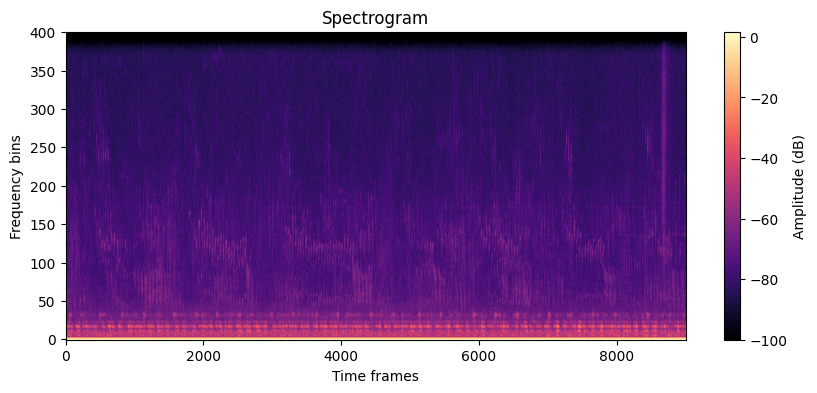

In [131]:
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_db, aspect='auto', origin='lower', cmap='magma')

plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.title("Spectrogram")

plt.show()

# Marine Mammals Detection
Per la detection dei vocalizzi dei mammiferi marini uso l'algoritmo di Weighted Signal Entropy come descritto nel paper [Entropy-Based Automatic Detection of Marine Mammal Tonal Calls](https://ieeexplore.ieee.org/document/10683973).
![Detection pipeline](media/docs/WSE_pipeline.gif)

## (b) Bandpass filter
Il file dato in input viene passato attraverso un filtro passa banda con una finestra di frequenze di limite superiore 15kHz.<br>
Il lower bound viene calcolato in modo adattivo secondo il seguente algoritmo:<br>
* Calcolo della short-time power spectral density (STPSD): serve per misurare come la potenza media del segnale è distribuita su frequenze diverse. La potenza media è la quantità di energia trasferita o distribuira in un intervallo di tempo. Si utilizza una Kaiser window e 2.5 Hz risoluzione di frequenza
* Vengono preparati i dati per il calcolo dell'entropia: $$p_{jk} = \frac{|s_{jk}|^{2}}{\sum _{j=1}^{J} |s_{jk}|^{2}},\;\; 1\leq j \leq J \tag{2}$$
* Viene calcolata la signal entropy per ogni intervallo di frequenza
* Posto un threshold di entropia a 0.85 il primo intervallo di frequenza con entropia superiore al threshold rappresenta il lower bound cercato

In [132]:
# Creazione della finestra di Kaiser con 2.5Hz risoluzione di frequenza
sample_num = int(samplerate/2.5)
kaiser_win = signal.windows.kaiser(sample_num, beta=14)

# Divisione in finestre del segnale
windowed_signal = x.reshape(-1, samplerate)
windowed_df = pd.DataFrame(windowed_signal)

# Calcolo della STPSD
psd_df = windowed_df.apply(lambda x: signal.welch(x, fs=samplerate, window=kaiser_win, nperseg=sample_num)[1], axis=1)
psd_df = psd_df.apply(pd.Series)
psd_df = psd_df.transpose()

psd_df.to_csv('media/docs/denorm.csv', index=False)

# Preparazione del dataframe per il calcolo dell'entropia
prob_df = psd_df.apply(lambda x: np.abs(x)**2)
prob_df["Sum"] = prob_df.sum(axis=1)
prob_df = prob_df.loc[:,prob_df.columns != 'Sum'].div(prob_df["Sum"], axis=0)


In [133]:
print(prob_df.shape)
prob_df.to_csv('media/docs/prob_df.csv', index=False)

(401, 3600)


In [134]:
# Calcolo dell'entropia per ogni bin di frquenze
base = 2
entropy_df = prob_df.apply(lambda x: stats.entropy(x, base=base), axis=1)
f = np.arange(0, 1002.5, 2.5)
entropy_df = pd.DataFrame({'Frequenze': f, 'Entropia': entropy_df})
entropy_df.to_csv('media/docs/entropy_df.csv', index=False)

# Selezione della frequenza con entropia non superiore a 0.85
lower_bound = entropy_df[entropy_df['Entropia'] < 0.85].max()['Frequenze']
print(f'Lower bound: {lower_bound} Hz')

Lower bound: 545.0 Hz


Text(0, 0.5, 'Spectral Entropy')

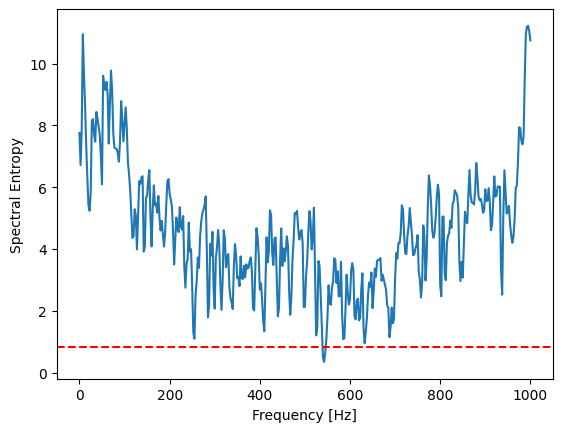

In [135]:
plt.plot(entropy_df['Frequenze'], entropy_df['Entropia'])
plt.axhline(0.85, color='red', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Spectral Entropy')